In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
from fastbook import *

     |████████████████████████████████| 727kB 12.0MB/s 
     |████████████████████████████████| 194kB 26.9MB/s 
     |████████████████████████████████| 1.1MB 34.4MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 40kB 5.4MB/s 
     |████████████████████████████████| 92kB 10.2MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 2.6MB 52.5MB/s 
Mounted at /content/gdrive


In [3]:
from fastai.vision.widgets import *
from fastai.vision.all import *

# Lesson 4 (suite): Gradient Descent with MNIST

In [7]:
from torchvision.datasets import MNIST

In [8]:
trainset = MNIST('../', download=True, train=True)
testset = MNIST('../', download=True, train=False)

Extracting ../MNIST/raw/train-images-idx3-ubyte.gz to ../MNIST/raw



Extracting ../MNIST/raw/train-labels-idx1-ubyte.gz to ../MNIST/raw


Extracting ../MNIST/raw/t10k-images-idx3-ubyte.gz to ../MNIST/raw


Extracting ../MNIST/raw/t10k-labels-idx1-ubyte.gz to ../MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
trainset.data[0]  # looks like a five

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170, 253, 253, 253, 253, 253, 2

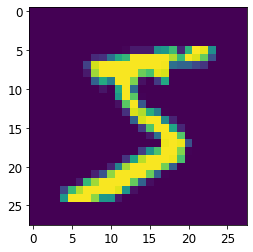

In [13]:
plt.imshow(trainset.data[0])

In [30]:
y_train = trainset.targets
y_test = testset.targets

y_train[0]  # indeed, the label for the first image is a 5

tensor(5)

In [15]:
# 60 000 images for training, 10 000 for testing
trainset.data.shape, testset.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [29]:
# So we've got 60 000 square images of 28*28 pixels
# Those square images are nice for plotting and seing what's in there, 
# but we can't pass them to a linear model
# as seen in the lesson, use view or reshape to have all the pixels for an image in a single row 

train = trainset.data.reshape(60000, -1)
test = testset.data.reshape(10000, -1)

assert train.shape[1] == 784
assert test.shape[1] == 784

In [31]:
# FLoating point numbers work better with pytorch...
train.dtype

torch.uint8

In [32]:
# So we pass the data to float32 torch tensors
train = train.to(torch.float32)
test = test.to(torch.float32)

In [33]:
# The data isn't normalized
m, std = train.mean(), train.std()
m, std

(tensor(33.3184), tensor(78.5675))

In [34]:
# So we normalize it
train = (train - m) / std
test = (test - m) / std
print(train.mean(), train.std())  # 0 and 1, good

tensor(1.8892e-08) tensor(1.)


## Define a fully connected neural net

In [51]:
def linear(x, neurons=50):
    # x is a n by m matrix;
    # to perform matrix operations, we want a 'm by neurons' matrix
    m = x.shape[1]
    w = torch.randn(m, neurons).requires_grad_()
    b = torch.randn(neurons).requires_grad_()
    return x @ w + b

In [52]:
def relu(x):
    return x.clamp_min(0.)

In [53]:
def model(x):
    x = linear(x, 50)
    x = relu(x)
    x = linear(x, 10)   # We want 10 outputs because we have 10 classes
    return x 

In [54]:
print("All possible classes (the numbers from 0 to 9):", y_train.unique())
print("That's", len(y_train.unique()), "classes")

All possible classes (the numbers from 0 to 9): tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
That's 10 classes


In [55]:
output = model(train)
output.shape

torch.Size([60000, 10])

So our model outputs 10 numbers for each image in our dataset. You can think of those ten numbers as follow: 

"For this image, what is the probability that it is a 0 ? a one ? a two ? ... a nine ?" 

But are those numbers real probabilities ?

In [56]:
output[0]

tensor([ 425.5692,  199.6936,   40.0095,  278.0396,   -3.7494,  144.4044, -231.4400,   -7.4895,   17.7265,  129.2715], grad_fn=<SelectBackward>)

Absolutely not: most are greater than one, some are negative, and their sum doesn't add to 1. We'll use a loss function that is called <b>cross-entropy</b>. We'll review in more details how Cross-Entropy works in a future notebook, but for now you just need a broad understanding of what it does.

It does two thing:

- transform those numbers into numbers that behave like probabilities (they will sum to 1, and none will be greater than 1 or inferior to 0).
- out of these 10 probability, it picks the one that relates to the class your model should have predicted. If this number happens to be 1, great: you predicted 100% probability that is was the correct class. If it's less than that, you get a penalty.

## Forward pass

In [57]:
output = model(train)
loss = F.cross_entropy(output, y_train)
loss

tensor(211.9291, grad_fn=<NllLossBackward>)

## Training loop

In [113]:
#Data and labels:
INPUT = train
TARGETS = y_train

# parameters we can change:
EPOCHS = 50
LR = 0.5

layer1 = torch.randn([784, 50]).requires_grad_()
activation = nn.ReLU()
layer2 = torch.randn([50, 10]).requires_grad_()

# Training loop
for i in range(EPOCHS):
    l1_output = activation(INPUT @ layer1)
    model_output = l1_output @ layer2

    loss = F.cross_entropy(model_output, TARGETS)
    if i%5 == 0:
        print(loss)
    loss.backward()
    with torch.no_grad():
        layer1 -= layer1.grad * LR
        layer2 -= layer2.grad * LR
        layer1.grad.zero_()
        layer2.grad.zero_()

tensor(242.6053, grad_fn=<NllLossBackward>)
tensor(4.6947, grad_fn=<NllLossBackward>)
tensor(3.2226, grad_fn=<NllLossBackward>)
tensor(2.8257, grad_fn=<NllLossBackward>)
tensor(2.6300, grad_fn=<NllLossBackward>)
tensor(2.5087, grad_fn=<NllLossBackward>)
tensor(2.4260, grad_fn=<NllLossBackward>)
tensor(2.3644, grad_fn=<NllLossBackward>)
tensor(2.3157, grad_fn=<NllLossBackward>)
tensor(2.2758, grad_fn=<NllLossBackward>)
